<h2 align='center'>Codebasics ML Course: ML Flow Tutorial</h2>

In [16]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

!pip install mlflow
!pip install xgboost

# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [17]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Step 1: Create an imbalanced binary classification dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=2, n_redundant=8, 
                           weights=[0.9, 0.1], flip_y=0, random_state=42)

np.unique(y, return_counts=True)

(array([0, 1]), array([900, 100]))

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Experiment 1: Train Logistic Regression Classifier

In [20]:
log_reg = LogisticRegression(C=1, solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print(classification_report(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       270
           1       0.60      0.50      0.55        30

    accuracy                           0.92       300
   macro avg       0.77      0.73      0.75       300
weighted avg       0.91      0.92      0.91       300



### Experiment 2: Train Random Forest Classifier

In [21]:
rf_clf = RandomForestClassifier(n_estimators=30, max_depth=3)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       270
           1       0.91      0.67      0.77        30

    accuracy                           0.96       300
   macro avg       0.94      0.83      0.87       300
weighted avg       0.96      0.96      0.96       300



### Experiment 3: Train XGBoost

In [22]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       270
           1       0.96      0.80      0.87        30

    accuracy                           0.98       300
   macro avg       0.97      0.90      0.93       300
weighted avg       0.98      0.98      0.98       300



### Experiment 4: Handle class imbalance using SMOTETomek and then Train XGBoost

In [23]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

np.unique(y_train_res, return_counts=True)

(array([0, 1]), array([619, 619]))

In [24]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       270
           1       0.81      0.83      0.82        30

    accuracy                           0.96       300
   macro avg       0.89      0.91      0.90       300
weighted avg       0.96      0.96      0.96       300



<h2 align="center" style="color:blue">Track Experiments Using MLFlow</h2>

In [25]:
models = [
    (
        "Logistic Regression", 
        LogisticRegression(C=1, solver='liblinear'), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Random Forest", 
        RandomForestClassifier(n_estimators=30, max_depth=3), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBClassifier",
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBClassifier With SMOTE",
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
        (X_train_res, y_train_res),
        (X_test, y_test)
    )
]

In [26]:
reports = []

for model_name, model, train_set, test_set in models:
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

In [27]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost

In [28]:
# Initialize MLflow
URL_MLFLOW = "http://34.126.111.16:5000"


mlflow.set_experiment("Anomaly Detection")
mlflow.set_tracking_uri(URL_MLFLOW)

for i, element in enumerate(models):
    model_name = element[0]
    model = element[1]
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_param("model", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('recall_class_1', report['1']['recall'])
        mlflow.log_metric('recall_class_0', report['0']['recall'])
        mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])        
        
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")  

MlflowException: Cannot set a deleted experiment 'Anomaly Detection' as the active experiment. You can restore the experiment, or permanently delete the experiment to create a new one.

# Example Results

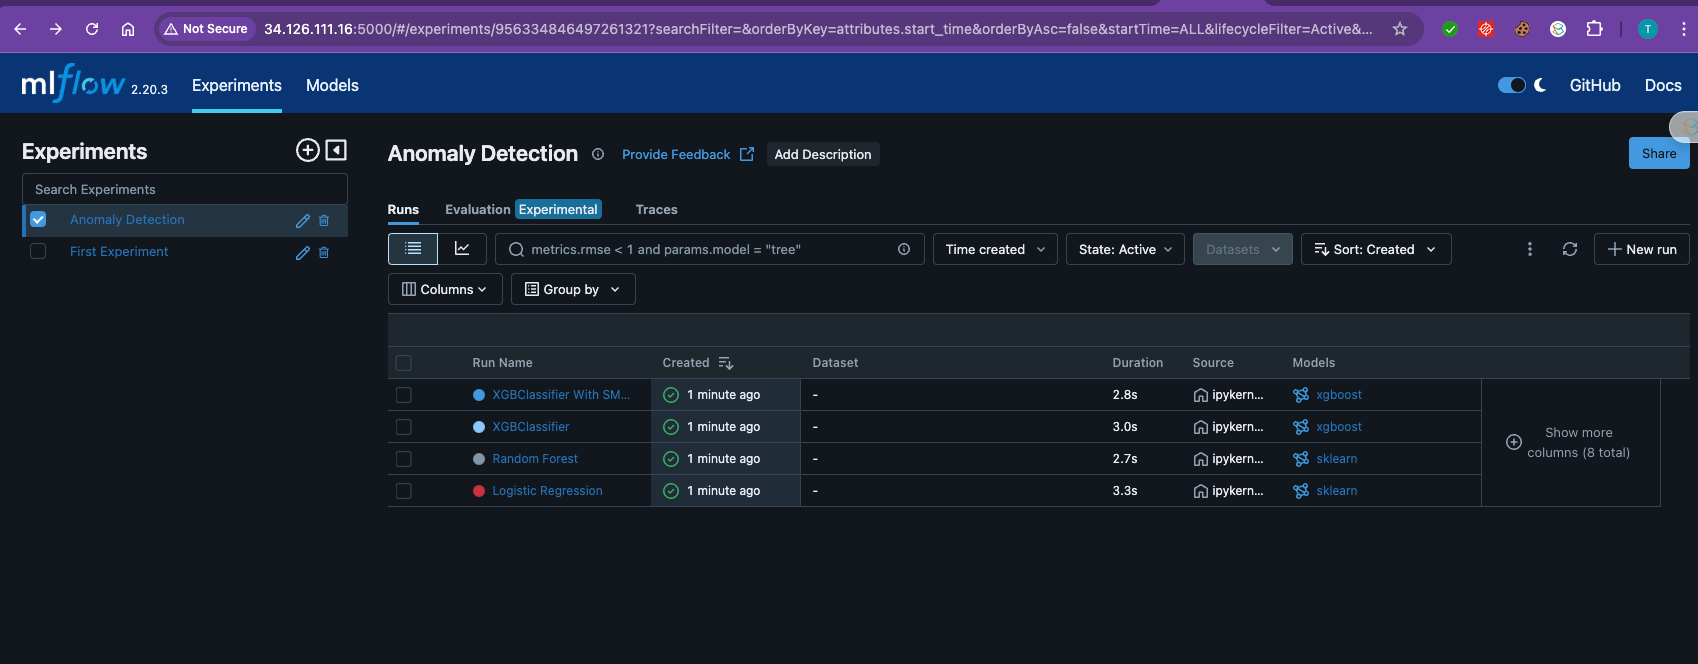

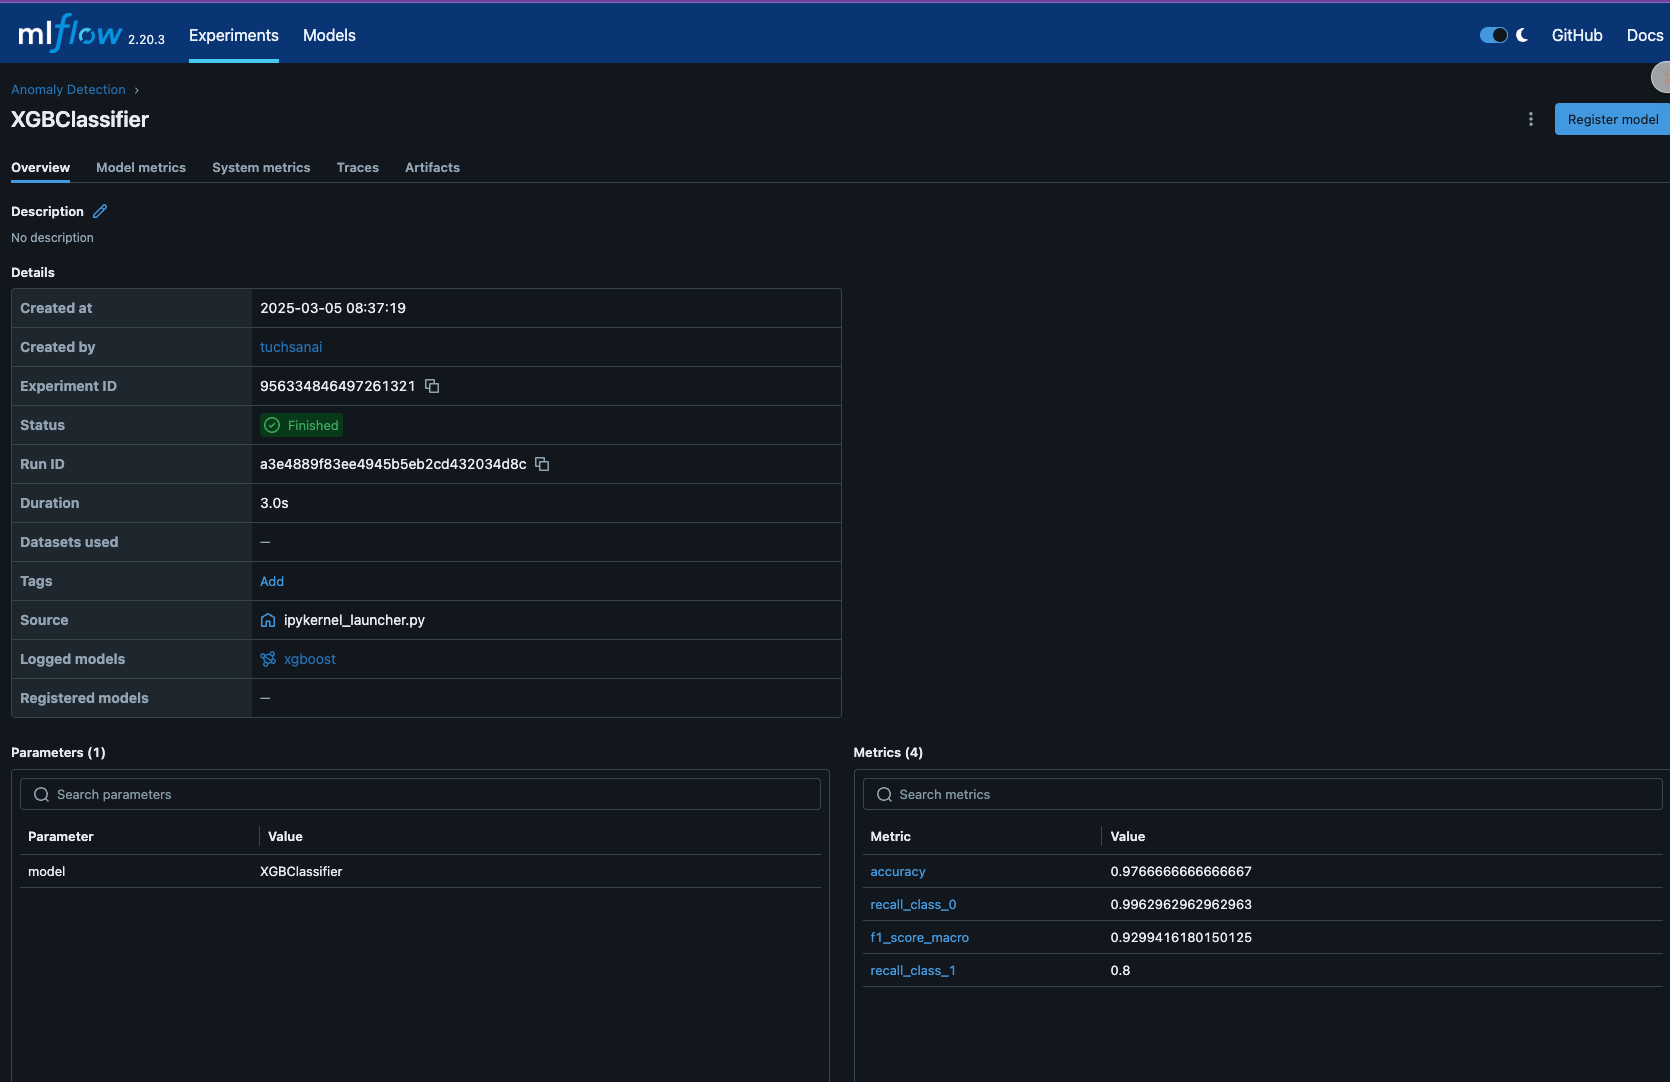